# Analyze output of .hdf5 files of hadrons code
June 12, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import sys

In [3]:
import gvar as gv
import h5py

In [4]:
sys.path.append('modules')
from modules_parse_hmc_Grid import *
from modules_measurement import *

In [5]:
# %matplotlib widget

In [6]:
%matplotlib notebook

m_f = 0.02 \
Want m_res < 10^-3

$ m_{phys} = m_f + m_{res} $ 

In [7]:
def f_get_meas_ensemble(run_dir,epoch_list,imag_part=False):
    '''
    Module to extract correlator data for a set of epochs for a run
    '''
    
    lst=[]
    for epoch in epoch_list:
        lst.append(f_get_meas(run_dir,epoch))
    
    keys = lst[0].keys()
    avg_dict={}
    
    for key in keys: 
        if (imag_part==True and key!='m_res'): # If input has imaginary part in array, extract real part
            a1=np.array([i[key][:,0]for i in lst])
        else: 
            a1=np.array([i[key] for i in lst])
            
            
        lgth=a1.shape[1]
        # Average over samples for each t-correlator
        avg_dict[key]=np.array([gv.dataset.avg_data(a1[:,i]) for i in range(lgth)])
    
    return avg_dict


def f_wflow_ensemble(flist,wf_time=90,var='plaq'):
    '''
    Get Wilson flow observables for fixed flow time
    Can plot variation vs epoch    
    '''
    
    obs_list=['flow_time', 'Plaq_density', 'Clover_density', 'top_charge', 'plaq', 'rect', 'ploop']
    assert var in obs_list, "Obsevable %s not in vars list %s"%(var,obs_list)
    
    cols=obs_list+['epoch']
    df=pd.DataFrame(columns=cols)
    
    dict1={}
    
    for count,fname in enumerate(flist):
        flow_vars=f_extract_wilson_flow(fname)
        
        dict1['epoch']=int(fname.split('/')[-1].split('.')[1])
        # Get values at fixed Wilsonflow time

        for key in obs_list:
#             print(key)
            if not key.endswith('ploop'):
                dict1[key] = np.array(flow_vars[key])[wf_time]
            else : 
                dict1[key] = np.array([complex(i,j) for i,j in zip(flow_vars['r_ploop'],flow_vars['i_ploop'])])[wf_time]
    
#         print(dict1)
        ## Append to Dataframe
        df=pd.concat([df,pd.DataFrame(dict1,index=[df.shape[0]+1])])

    return df
    

def f_plot(df,obs):
    '''
    Plot variation with epoch for given observables
    For polyakov loop, also make scatter plot along with absolute value plot
    '''
    
    x=df.epoch.values
    y=df[obs].values

    if obs=='ploop':
        plt.figure()
        plt.scatter(y.real,y.imag,marker='H')
        plt.xlabel('real part')
        plt.ylabel('imag part')
        plt.show()
        
    plt.figure()
    if obs=='ploop':  y=np.abs(y)
    
    plt.plot(x,y,linestyle='',marker='*')
    plt.xlabel('epoch')
    plt.title(obs)
    plt.show()
    
    

def f_plot_compare(df,obs):
    '''
    
    '''
    
    x = df['beta'].values
    y = df[obs].values

    plt.figure()
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',marker='o')
    plt.xlabel('beta')
    plt.ylabel(obs)


def f_avg_obs(df,L):
    
    dict1={}
    for col in df.columns:
        if col =='ploop':
            y=np.abs(df[col].values)
            dict1['mag_ploop']=gv.dataset.avg_data(y)
            dict1['sus_poly'],dict1['kurt_poly']=f_moments(y,L)
            # Complex Polyakov loop
            dict1['ploop']    =[gv.dataset.avg_data(np.real(df[col])),gv.dataset.avg_data(np.imag(df[col]))]

        elif col in ['flow_time','epoch']:
            pass
        else : 
            y=df[col].values
            dict1[col] =gv.dataset.avg_data(y)
            dict1['sus_'+col],dict1['kurt_'+col]=f_moments(y,L)
            
    dict1['num_epochs']=df.shape[0]
    
    return dict1


## 1. Compare runs

In [8]:
top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_7_hot_start/'
# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_8_cold_start/'


In [9]:
cols=['Plaq_density', 'Clover_density', 'top_charge', 'plaq', 'rect', 'mag_ploop', 'ploop']
df=pd.DataFrame()

dict1={}
for run_dir in glob.glob(top_dir+'meas*/*-tioga/'):

    beta=float(run_dir.split('/')[-3].split('beta-')[-1].split('_')[0])
    mf=float(run_dir.split('/')[-3].split('mf-')[-1])
    L=int(run_dir.split('/')[-3].split('Lx-')[-1].split('_')[0])
    
    dict1['beta']=beta
    dict1['mf']=mf
    
    flist=glob.glob(run_dir+'Wflow*')
    
    df_epoch=f_wflow_ensemble(flist,2,'ploop')
    d_avg=f_avg_obs(df_epoch,L)
    
    
#     display(df_epoch)
#     print(d_avg)
    
    for key in d_avg.keys():
        if key!='ploop': dict1[key]=d_avg[key]
        
#     print(dict1)
    df=pd.concat([df,pd.DataFrame(dict1,index=[df.shape[0]+1])])
    
df

,beta,mf,Plaq_density,sus_Plaq_density,kurt_Plaq_density,Clover_density,sus_Clover_density,kurt_Clover_density,top_charge,sus_top_charge,...,plaq,sus_plaq,kurt_plaq,rect,sus_rect,kurt_rect,mag_ploop,sus_poly,kurt_poly,num_epochs
1,11.0,0.1,0.0114869(16),1.58(17)e-06,1.59(28)e-07,0.00230506(34),7.16(79)e-08,nan +- nan,0.178(62),2401(291),...,0.645466(49),0.00150(16),1.59(28)e-07,0.433894(73),0.00332(35),1.60(30)e-07,0.04187(48),0.145(19),2.16(73)e-07,154
2,11.1,0.1,0.0112870(19),1.35(22)e-06,1.99(70)e-07,0.00227518(38),5.58(83)e-08,nan +- nan,0.306(82),2540(326),...,0.651635(58),0.00129(21),1.99(70)e-07,0.442439(85),0.00275(43),1.95(65)e-07,0.04580(89),0.302(43),1.68(51)e-07,93
3,11.2,0.1,0.0110982(18),1.42(18)e-06,1.62(44)e-07,0.00224501(38),6.34(89)e-08,nan +- nan,-0.020(79),2753(357),...,0.657462(56),0.00135(17),1.62(44)e-07,0.450694(81),0.00289(39),1.77(51)e-07,0.05676(70),0.215(31),1.89(54)e-07,107
4,11.3,0.1,0.0109198(12),9.9(1.0)e-07,1.70(34)e-07,0.00221795(28),5.82(63)e-08,nan +- nan,-0.250(59),2513(277),...,0.662970(36),0.000945(96),1.70(34)e-07,0.458419(55),0.00225(24),1.81(37)e-07,0.05996(55),0.224(22),1.64(30)e-07,179
5,11.4,0.1,0.0107464(12),1.07(13)e-06,2.08(62)e-07,0.00219042(26),4.83(54)e-08,nan +- nan,-0.048(55),2154(213),...,0.668321(37),0.00102(12),2.08(62)e-07,0.466009(55),0.00219(26),2.04(52)e-07,0.07136(48),0.164(16),1.59(27)e-07,177
6,11.5,0.1,0.0105849(15),9.0(1.5)e-07,2.31(89)e-07,0.00216506(38),6.08(89)e-08,nan +- nan,-0.021(65),1774(283),...,0.673304(45),0.00086(14),2.31(89)e-07,0.473082(72),0.00218(36),2.25(83)e-07,0.07815(63),0.165(23),1.79(68)e-07,102
7,11.6,0.1,0.0104278(15),9.5(1.4)e-07,1.91(56)e-07,0.00213986(37),5.99(72)e-08,nan +- nan,-0.066(70),2109(254),...,0.678153(46),0.00090(13),1.91(56)e-07,0.480001(72),0.00221(30),1.74(46)e-07,0.08373(66),0.185(24),1.64(39)e-07,105
8,11.7,0.1,0.0102796(15),9.1(1.3)e-07,1.85(48)e-07,0.00211671(36),5.55(75)e-08,nan +- nan,0.141(64),1771(259),...,0.682728(45),0.00086(12),1.85(48)e-07,0.486473(70),0.00207(31),1.98(65)e-07,0.08801(77),0.253(33),1.64(40)e-07,104
9,11.8,0.1,0.0101352(13),7.8(1.1)e-07,1.72(47)e-07,0.00209374(31),4.14(52)e-08,nan +- nan,0.110(66),1863(270),...,0.687184(42),0.00074(10),1.72(47)e-07,0.492840(62),0.00164(20),1.51(34)e-07,0.09328(67),0.194(29),1.99(62)e-07,105
10,11.9,0.1,0.0099947(13),7.05(93)e-07,1.72(45)e-07,0.00207037(34),5.07(78)e-08,nan +- nan,0.016(66),1968(237),...,0.691522(39),0.000672(89),1.72(45)e-07,0.499131(61),0.00165(23),1.88(46)e-07,0.10041(61),0.165(20),1.54(33)e-07,109


<IPython.core.display.Javascript object>


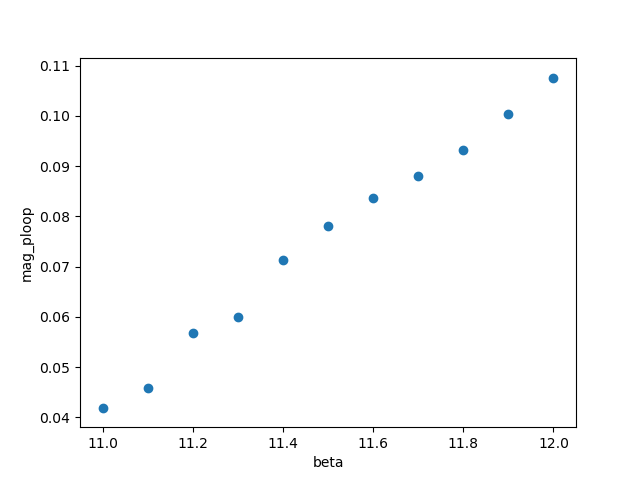

In [10]:
f_plot_compare(df,'mag_ploop')

In [11]:
# obs='top_charge'
# f_plot_compare(df,obs)
# plt.savefig('wflow_%s.pdf'%(obs))

<IPython.core.display.Javascript object>


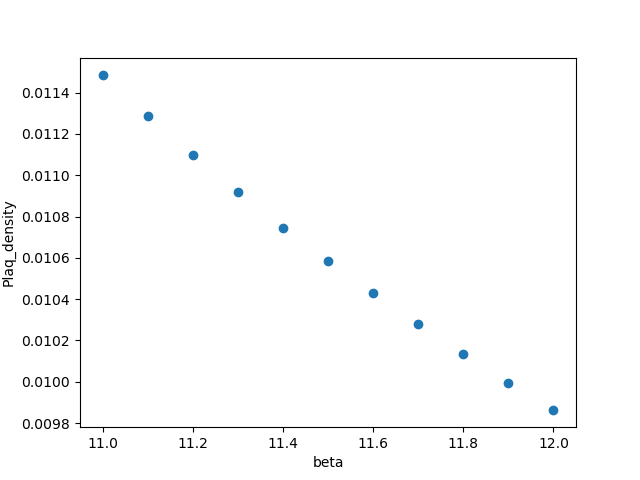

<IPython.core.display.Javascript object>


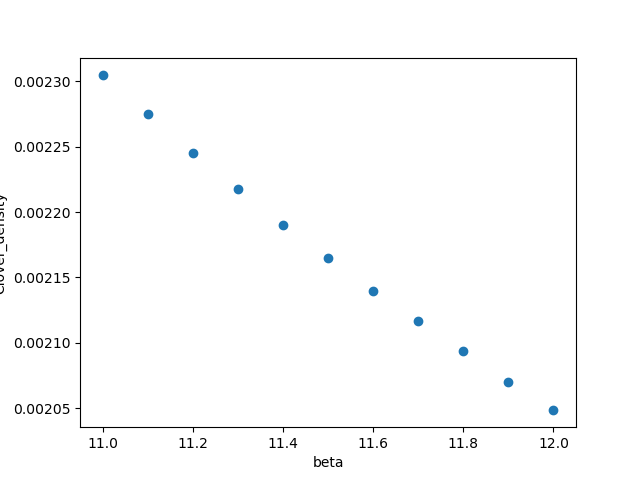

<IPython.core.display.Javascript object>


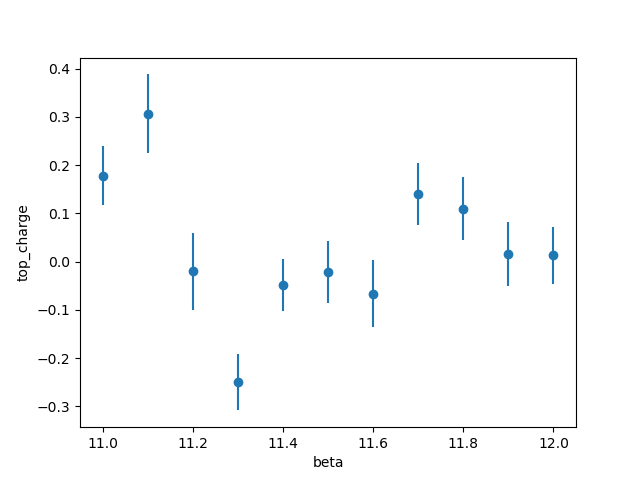

<IPython.core.display.Javascript object>


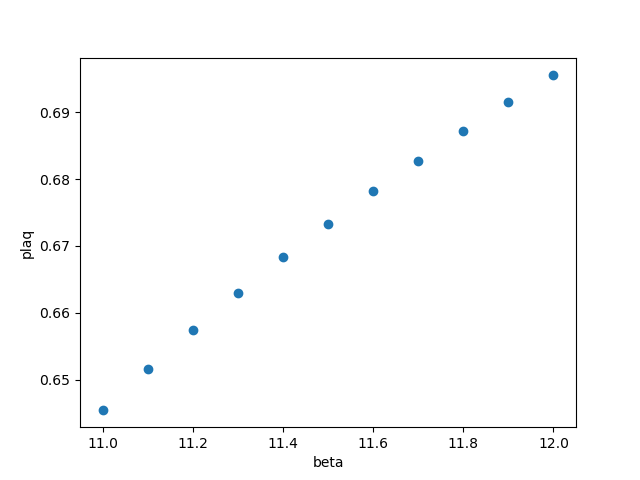

<IPython.core.display.Javascript object>


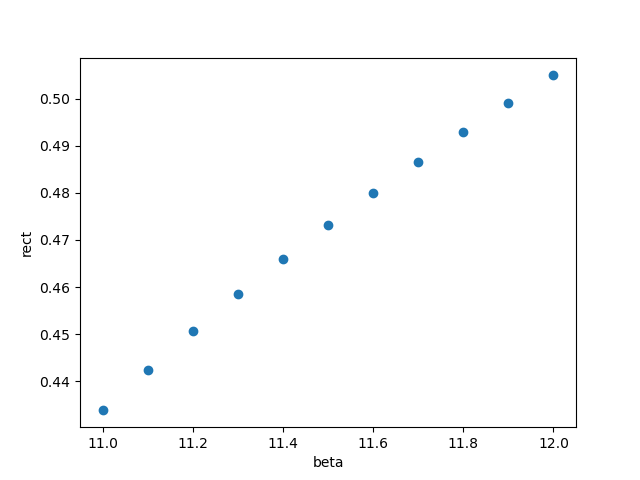

<IPython.core.display.Javascript object>


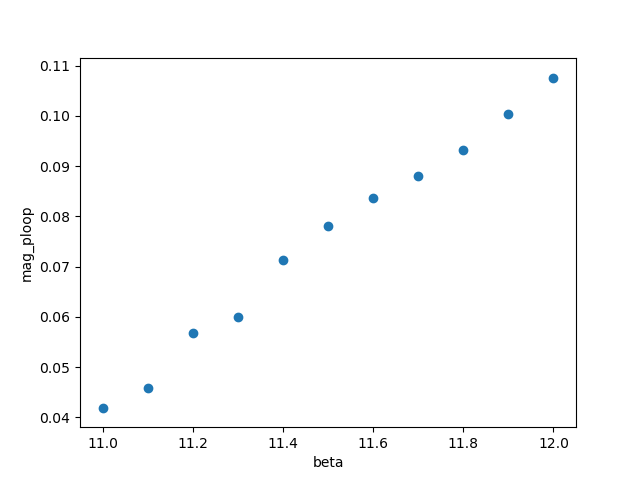

<IPython.core.display.Javascript object>


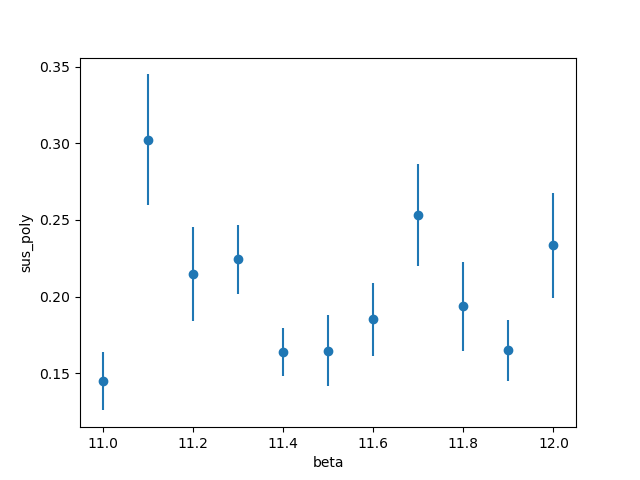

In [12]:
for obs in ['Plaq_density','Clover_density','top_charge','plaq','rect','mag_ploop','sus_poly']:
    f_plot_compare(df,obs)
#     plt.savefig('wflow_%s.pdf'%(obs))

In [13]:
df

,beta,mf,Plaq_density,sus_Plaq_density,kurt_Plaq_density,Clover_density,sus_Clover_density,kurt_Clover_density,top_charge,sus_top_charge,...,plaq,sus_plaq,kurt_plaq,rect,sus_rect,kurt_rect,mag_ploop,sus_poly,kurt_poly,num_epochs
1,11.0,0.1,0.0114869(16),1.58(17)e-06,1.59(28)e-07,0.00230506(34),7.16(79)e-08,nan +- nan,0.178(62),2401(291),...,0.645466(49),0.00150(16),1.59(28)e-07,0.433894(73),0.00332(35),1.60(30)e-07,0.04187(48),0.145(19),2.16(73)e-07,154
2,11.1,0.1,0.0112870(19),1.35(22)e-06,1.99(70)e-07,0.00227518(38),5.58(83)e-08,nan +- nan,0.306(82),2540(326),...,0.651635(58),0.00129(21),1.99(70)e-07,0.442439(85),0.00275(43),1.95(65)e-07,0.04580(89),0.302(43),1.68(51)e-07,93
3,11.2,0.1,0.0110982(18),1.42(18)e-06,1.62(44)e-07,0.00224501(38),6.34(89)e-08,nan +- nan,-0.020(79),2753(357),...,0.657462(56),0.00135(17),1.62(44)e-07,0.450694(81),0.00289(39),1.77(51)e-07,0.05676(70),0.215(31),1.89(54)e-07,107
4,11.3,0.1,0.0109198(12),9.9(1.0)e-07,1.70(34)e-07,0.00221795(28),5.82(63)e-08,nan +- nan,-0.250(59),2513(277),...,0.662970(36),0.000945(96),1.70(34)e-07,0.458419(55),0.00225(24),1.81(37)e-07,0.05996(55),0.224(22),1.64(30)e-07,179
5,11.4,0.1,0.0107464(12),1.07(13)e-06,2.08(62)e-07,0.00219042(26),4.83(54)e-08,nan +- nan,-0.048(55),2154(213),...,0.668321(37),0.00102(12),2.08(62)e-07,0.466009(55),0.00219(26),2.04(52)e-07,0.07136(48),0.164(16),1.59(27)e-07,177
6,11.5,0.1,0.0105849(15),9.0(1.5)e-07,2.31(89)e-07,0.00216506(38),6.08(89)e-08,nan +- nan,-0.021(65),1774(283),...,0.673304(45),0.00086(14),2.31(89)e-07,0.473082(72),0.00218(36),2.25(83)e-07,0.07815(63),0.165(23),1.79(68)e-07,102
7,11.6,0.1,0.0104278(15),9.5(1.4)e-07,1.91(56)e-07,0.00213986(37),5.99(72)e-08,nan +- nan,-0.066(70),2109(254),...,0.678153(46),0.00090(13),1.91(56)e-07,0.480001(72),0.00221(30),1.74(46)e-07,0.08373(66),0.185(24),1.64(39)e-07,105
8,11.7,0.1,0.0102796(15),9.1(1.3)e-07,1.85(48)e-07,0.00211671(36),5.55(75)e-08,nan +- nan,0.141(64),1771(259),...,0.682728(45),0.00086(12),1.85(48)e-07,0.486473(70),0.00207(31),1.98(65)e-07,0.08801(77),0.253(33),1.64(40)e-07,104
9,11.8,0.1,0.0101352(13),7.8(1.1)e-07,1.72(47)e-07,0.00209374(31),4.14(52)e-08,nan +- nan,0.110(66),1863(270),...,0.687184(42),0.00074(10),1.72(47)e-07,0.492840(62),0.00164(20),1.51(34)e-07,0.09328(67),0.194(29),1.99(62)e-07,105
10,11.9,0.1,0.0099947(13),7.05(93)e-07,1.72(45)e-07,0.00207037(34),5.07(78)e-08,nan +- nan,0.016(66),1968(237),...,0.691522(39),0.000672(89),1.72(45)e-07,0.499131(61),0.00165(23),1.88(46)e-07,0.10041(61),0.165(20),1.54(33)e-07,109


## 2. Explore ensemble
View variation for a set of configs for specific beta, mf

In [14]:
## Choose specific beta from above dataframe

beta=11.4
run_dir=glob.glob(top_dir+'meas_run_Lx-16_Lt-8_Ls-16_beta-{0}_mf-0.1/*-tioga'.format(beta))[0]+'/'
print(run_dir)

/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_7_hot_start/meas_run_Lx-16_Lt-8_Ls-16_beta-11.4_mf-0.1/090723_083720-tioga/


In [15]:
# # Alternatively, provide the full directory path to specific run
# run_dir=glob.glob('/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_7_hot_start/meas_run_Lx-16_Lt-8_Ls-16_beta-11.4_mf-0.1/*-tioga')[0]+'/'
# print(run_dir)


### Correlator plots

<IPython.core.display.Javascript object>


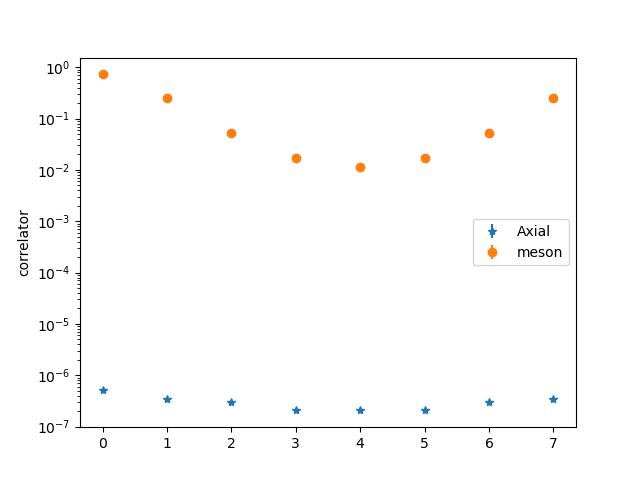

<IPython.core.display.Javascript object>


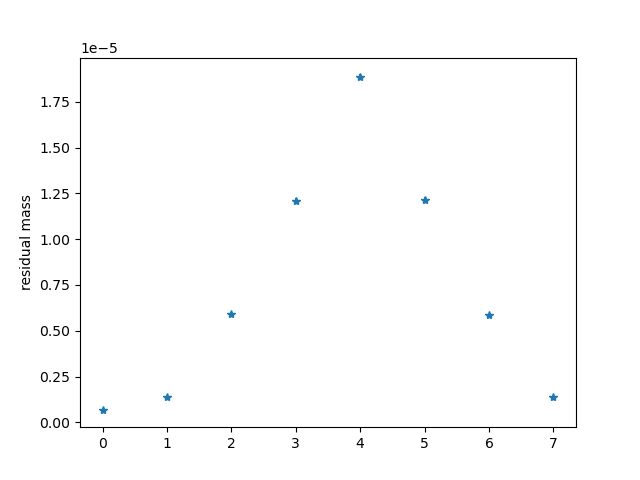

In [16]:
epoch_list=[i.split('/')[-1].split('.')[1] for i in glob.glob(run_dir+'eta_*')]

avg_dict=f_get_meas_ensemble(run_dir,epoch_list)
f_plot_mres(avg_dict,plot_ensemble=True,plot_corr=True)


### Wilson flow 

In [17]:
flist=glob.glob(run_dir+'Wflow*')
wflow_time=50

df_epoch=f_wflow_ensemble(flist,wflow_time,'ploop')
df_epoch

,flow_time,Plaq_density,Clover_density,top_charge,plaq,rect,ploop,epoch
1,0.51,0.197444,0.134941,-0.774847,0.978914,0.939574,-0.332033+0.010905j,455
2,0.51,0.197971,0.135658,-0.703328,0.978857,0.939358,-0.298126-0.000860j,460
3,0.51,0.196249,0.134181,-0.695211,0.979041,0.939931,-0.309970-0.005465j,465
4,0.51,0.196641,0.134389,-0.680267,0.978999,0.939830,-0.295621+0.002898j,470
5,0.51,0.197456,0.135235,-0.774747,0.978912,0.939530,-0.307106+0.016901j,475
...,...,...,...,...,...,...,...,...
173,0.51,0.198054,0.135339,0.081387,0.978849,0.939411,-0.354420-0.005000j,1315
174,0.51,0.197613,0.134990,0.143742,0.978896,0.939549,-0.336718-0.008347j,1320
175,0.51,0.195963,0.134251,-0.162169,0.979072,0.939979,-0.335524-0.004665j,1325
176,0.51,0.196269,0.134352,0.052971,0.979039,0.939902,-0.282536-0.000708j,1330


<IPython.core.display.Javascript object>


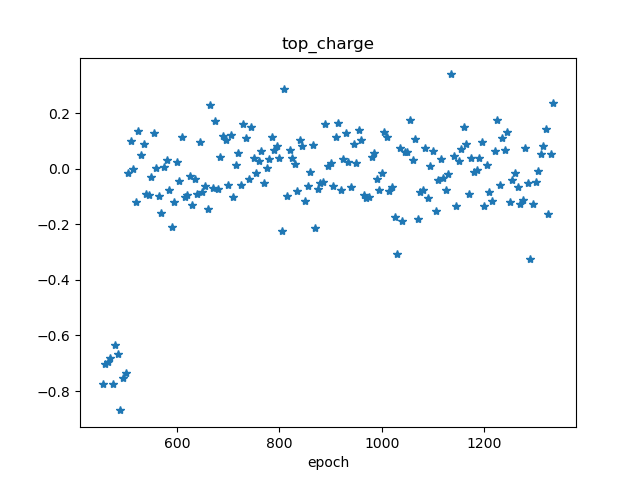

In [18]:
# f_plot(df_epoch,'ploop')
f_plot(df_epoch,'top_charge')

## 3. Explore single measurement
View variation for a specific config

In [19]:
run_dir=glob.glob(top_dir+'meas_run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1/*-tioga')[0]+'/'
print(run_dir)

/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_7_hot_start/meas_run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1/090723_054620-tioga/


In [20]:
# Alternatively, provide the full directory path to specific run
# run_dir=glob.glob('/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_7_hot_start/meas_run_Lx-16_Lt-8_Ls-16_beta-11.4_mf-0.1/*-tioga')[0]+'/'
# print(run_dir)


In [21]:
epoch_list=[i.split('/')[-1].split('.')[1] for i in glob.glob(run_dir+'eta_*')]
print(epoch_list)

['255', '260', '265', '270', '275', '280', '285', '290', '295', '300', '305', '310', '315', '320', '325', '330', '335', '340', '345', '350', '355', '360', '365', '370', '375', '380', '385', '390', '395', '400', '405', '410', '415', '420', '425', '430', '435', '440', '445', '450', '455', '460', '465', '470', '475', '480', '485', '490', '495', '500', '505', '510', '515', '520', '525', '530', '535', '540', '545', '550', '555', '560', '565', '570', '575', '580', '585', '590', '595', '600', '605', '610', '615', '620', '625', '630', '635', '640', '645', '650', '655', '660', '665', '670', '675', '680', '685', '690', '695', '700', '705', '710', '715', '720', '725', '730', '735', '740', '745', '750', '755', '760', '765', '770', '775', '780', '785', '790', '795', '800', '805', '810', '815', '820', '825', '830', '835', '840', '845', '850', '855', '860', '865', '870', '875', '880', '885', '890', '895', '900', '905', '910', '915', '920', '925', '930', '935', '940', '945', '950', '955', '960', '965'

### Correlators

In [ ]:
epoch=1315
print("Epoch",epoch)

In [ ]:
m1=f_get_meas(run_dir,epoch,True)
f_plot_mres(m1,False)
plt.show()

### Wilson flow

In [ ]:
fname=run_dir+'Wflow_.{0}.h5'.format(epoch)

flow_vars=f_extract_wilson_flow(fname)

# Plot Wilson flow results
keys=['flow_time','Plaq_density','Clover_density','top_charge','plaq','rect','r_ploop','i_ploop']

plt.figure()
for key,marker in zip(keys,itertools.cycle('>^*sDHPdpx_')):
    plt.plot(flow_vars[key],linestyle='',marker=marker,label=key)
    
plt.legend(loc='best')
